# Semester Project - in Python 

**this section is under development, students should continue to use ModelMuse**, the python is not particularly intuitive.

Here is a python approach to access MODFLOW6 using Jupyter Notebook running an ipython kernel.

There was an installation step for FloPy and manual compilation of MODFLOW6 to run on a Raspberry Pi (to make the notes)  Use the `! get-modflow` method in the notes for intel-based machines.

## Step 1 

- Build MODFLOW6 on server (I used a raspberry pi, the install notes show how to get binaries directly for intel machines)
- Convert example problem into the 5-layer case to understand the model syntax.
- Use a default recharge package from [modflow6-examples.readthedocs.io](https://modflow6-examples.readthedocs.io/en/latest/_notebooks/ex-gwf-twri.html)
- Use a wellfield package to include wells (adjust pumpage as needed to activate/deactivate)


In [16]:
import warnings
warnings.filterwarnings('ignore')

# Now attempt an example
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

name = "project1-1_mf6"
h1 = 100
h2 = 90
hriv = -25 #river elevation reference to top
Nlay = 5 #number layers
Nrow = 24 #number rows
Ncol = 10 #number columns
LR = Nrow*1000.0 # length in row direction
LC = Ncol*1000.0 # length in column direction
H = 175.0 # aquifer thickness
k = 20.0*365 # hydraulic condictivity

sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6", version="mf6", sim_ws="/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/project1-1"
)

tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="YEARS", nper=1, perioddata=[(1.0, 1, 1.0)]
)

ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE")

model_nam_file = "{}.nam".format(name)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

#bot = np.linspace(-H / Nlay, -H, Nlay)
bot = np.array([-50,-95,-100,-150,-175])
#print(bot)
delrow = LR/Nrow
delcol = LC/Ncol
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=Nlay,
    nrow=Nrow,
    ncol=Ncol,
    delr=delrow,
    delc=delcol,
    top=0.0,
    botm=bot,
)

#start heads
start = hriv * np.ones((Nlay, Nrow, Ncol))
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k, save_flows=True)

# create constant head boundaries
chd_rec = []
#chd_rec.append(((0, 19, 5), hriv))
for layer in range(0, 1):
    for col in range(0,Ncol):
        chd_rec.append(((layer, 8, col), hriv))

chd = flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True,
)

# ### Create the well (`WEL`) Package
#
# Add a well in model layer 5.

wel_rec = []
wel_rec.append((0, 21, 5, -1)) #wellfieldA-upper
wel_rec.append((1, 21, 5, -1)) #wellfieldA-lower
wel_rec.append((3, 14, 6, -1)) #wellfieldB-upper
wel_rec.append((4, 14, 6, -1)) #wellfieldB-lower
wel_rec.append((3, 4, 6, -1)) #wellfieldC-upper
wel_rec.append((4, 4, 6, -1)) #wellfieldC-lower
#wel_rec = [(4, 21, 5, -1000)]
wel = flopy.mf6.ModflowGwfwel(
    gwf,
    stress_period_data=wel_rec,
)

iper = 0
ra = chd.stress_period_data.get_data(key=iper)
#ra

flopy.mf6.ModflowGwfrcha(gwf, recharge=2.5e-1)

# Create the output control (`OC`) Package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

sim.write_simulation()



import tracemalloc
tracemalloc.start() # this is to suppress an asyncronous warning

# attempt to run the model, will see if binary loaded OK
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

current, peak = tracemalloc.get_traced_memory()
print("Current memory usage is %d bytes; peak was %d bytes" % (current, peak))

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model project1-1_mf6...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 6 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...
FloPy is using the following executable to run the model: /home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

         MODFLOW 6 compiled Apr 16 2023 18:27:14 with GCC version 9.4.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS re

<a list of 35 text.Text objects>

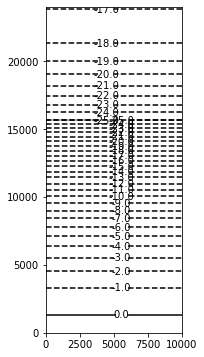

In [17]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(0, 0))
x = np.linspace(0, LC, Ncol )
y = np.linspace(0, LR, Nrow )
y = y[::-1]
vmin, vmax = -175.0, 0.0
contour_intervals = np.arange(-175, 10, 1.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.clabel(c, fmt="%2.1f")
#print(contour_intervals)

<a list of 33 text.Text objects>

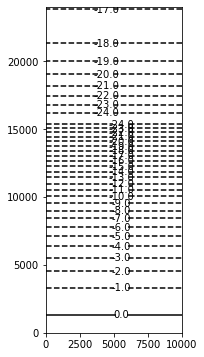

In [18]:
# ### Plot a Map of Layer 5

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[4], contour_intervals, colors="black")
plt.clabel(c, fmt="%2.1f")

<a list of 33 text.Text objects>

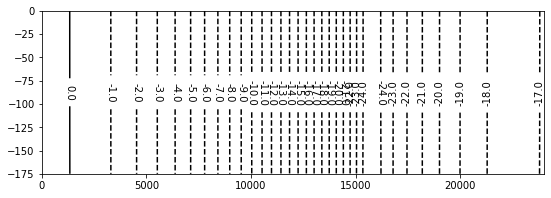

In [22]:
# now try a slice
# ### Plot a Cross-section along column 6

z = np.linspace(-175, 0 , Nlay)
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1, aspect="auto")
c = ax.contour(y, z, h[:, :,5], contour_intervals, colors="black")
plt.clabel(c, fmt="%1.1f")


## Step 2 (and beyond)

Ok seems to be a running model, 5 layers, with a constant head boundary and recharge.

The next step is to activete the wellfields, then figure out how to define spatial varying $K$ for each layer, then spatial varying $S$ for each layer without breaking the model.  Then turn into transient simulator, and run the time-varying cases.

Next case is with wellfield C at the lower bound of pumpage rate.  Flow is towards river cells - so feasible as per problem statement.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Now attempt an example
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

name = "project1-1_mf6"
h1 = 100
h2 = 90
hriv = -25 #river elevation reference to bottom
Nlay = 5 #number layers
Nrow = 24 #number rows
Ncol = 10 #number columns
LR = Nrow*1000.0 # length in row direction
LC = Ncol*1000.0 # length in column direction
H = 175.0 # aquifer thickness
k = 20.0*365 # hydraulic condictivity

sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6", version="mf6", sim_ws="/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/project1-1"
)

tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="YEARS", nper=1, perioddata=[(1.0, 1, 1.0)]
)

ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE")

model_nam_file = "{}.nam".format(name)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

#bot = np.linspace(-H / Nlay, -H, Nlay)
bot = np.array([-50,-95,-100,-150,-175])
#bot = np.array([125,80,75,25,0])
#print(bot)
delrow = LR/Nrow
delcol = LC/Ncol
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=Nlay,
    nrow=Nrow,
    ncol=Ncol,
    delr=delrow,
    delc=delcol,
    top=0.0,
    botm=bot,
)

#start heads
start = hriv * np.ones((Nlay, Nrow, Ncol))
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k, save_flows=True)

# create constant head boundaries
chd_rec = []
#chd_rec.append(((0, 19, 5), hriv))
for layer in range(0, 1):
    for col in range(0,Ncol):
        chd_rec.append(((layer, 8, col), hriv))

chd = flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True,
)

# ### Create the well (`WEL`) Package
#
# Add a well in model layer 5.

wel_rec = []
wel_rec.append((0, 21, 5, -5.0e06)) #wellfieldA-upper
wel_rec.append((1, 21, 5, -5.0e06)) #wellfieldA-lower
wel_rec.append((3, 14, 6, -8.0e06)) #wellfieldB-upper
wel_rec.append((4, 14, 6, -8.0e06)) #wellfieldB-lower
wel_rec.append((3, 4, 6, -7.5e06*1)) #wellfieldC-upper
wel_rec.append((4, 4, 6, -7.5e06*1)) #wellfieldC-lower
#wel_rec = [(4, 21, 5, -1000)]
wel = flopy.mf6.ModflowGwfwel(
    gwf,
    stress_period_data=wel_rec,
)

iper = 0
ra = chd.stress_period_data.get_data(key=iper)
#ra

flopy.mf6.ModflowGwfrcha(gwf, recharge=2.5e-1)

# Create the output control (`OC`) Package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

sim.write_simulation()



import tracemalloc
tracemalloc.start() # this is to suppress an asyncronous warning

# attempt to run the model, will see if binary loaded OK
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

current, peak = tracemalloc.get_traced_memory()
print("Current memory usage is %d bytes; peak was %d bytes" % (current, peak))

In [ ]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(0, 0))
x = np.linspace(0, LC, Ncol )
y = np.linspace(0, LR, Nrow )
y = y[::-1]
vmin, vmax = -175.0, 0.0
contour_intervals = np.arange(-175, 10, 1.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.clabel(c, fmt="%2.1f")
#print(contour_intervals)

In [ ]:
# ### Plot a Map of Layer 5

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[4], contour_intervals, colors="black")
plt.clabel(c, fmt="%2.1f")

In [ ]:
# now try a slice
# ### Plot a Cross-section along column 6

z = np.linspace(-175, 1 , Nlay)
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1, aspect="auto")
c = ax.contour(y, z, h[:, :,5], contour_intervals, colors="black")
plt.clabel(c, fmt="%1.1f")


Wellfield C at maximum target rate, notice in the slice, that there is flow from the river cells to the north, so this is too much pumpage as per the problem statement.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Now attempt an example
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

name = "project1-1_mf6"
h1 = 100
h2 = 90
hriv = -25 #river elevation reference to bottom
Nlay = 5 #number layers
Nrow = 24 #number rows
Ncol = 10 #number columns
LR = Nrow*1000.0 # length in row direction
LC = Ncol*1000.0 # length in column direction
H = 175.0 # aquifer thickness
k = 20.0*365 # hydraulic condictivity

sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6", version="mf6", sim_ws="/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/project1-1"
)

tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="YEARS", nper=1, perioddata=[(1.0, 1, 1.0)]
)

ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE")

model_nam_file = "{}.nam".format(name)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

#bot = np.linspace(-H / Nlay, -H, Nlay)
bot = np.array([-50,-95,-100,-150,-175])
#bot = np.array([125,80,75,25,0])
#print(bot)
delrow = LR/Nrow
delcol = LC/Ncol
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=Nlay,
    nrow=Nrow,
    ncol=Ncol,
    delr=delrow,
    delc=delcol,
    top=0.0,
    botm=bot,
)

#start heads
start = hriv * np.ones((Nlay, Nrow, Ncol))
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k, save_flows=True)

# create constant head boundaries
chd_rec = []
#chd_rec.append(((0, 19, 5), hriv))
for layer in range(0, 1):
    for col in range(0,Ncol):
        chd_rec.append(((layer, 8, col), hriv))

chd = flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True,
)

# ### Create the well (`WEL`) Package
#
# Add a well in model layer 5.

wel_rec = []
wel_rec.append((0, 21, 5, -5.0e06)) #wellfieldA-upper
wel_rec.append((1, 21, 5, -5.0e06)) #wellfieldA-lower
wel_rec.append((3, 14, 6, -8.0e06)) #wellfieldB-upper
wel_rec.append((4, 14, 6, -8.0e06)) #wellfieldB-lower
wel_rec.append((3, 4, 6, -7.5e06*2)) #wellfieldC-upper
wel_rec.append((4, 4, 6, -7.5e06*2)) #wellfieldC-lower
#wel_rec = [(4, 21, 5, -1000)]
wel = flopy.mf6.ModflowGwfwel(
    gwf,
    stress_period_data=wel_rec,
)

iper = 0
ra = chd.stress_period_data.get_data(key=iper)
#ra

flopy.mf6.ModflowGwfrcha(gwf, recharge=2.5e-1)

# Create the output control (`OC`) Package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

sim.write_simulation()



import tracemalloc
tracemalloc.start() # this is to suppress an asyncronous warning

# attempt to run the model, will see if binary loaded OK
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

current, peak = tracemalloc.get_traced_memory()
print("Current memory usage is %d bytes; peak was %d bytes" % (current, peak))

In [ ]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(0, 0))
x = np.linspace(0, LC, Ncol )
y = np.linspace(0, LR, Nrow )
y = y[::-1]
vmin, vmax = -175.0, 0.0
contour_intervals = np.arange(-175, 10, 1.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.clabel(c, fmt="%2.1f")
#print(contour_intervals)

In [ ]:
# ### Plot a Map of Layer 5

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[4], contour_intervals, colors="black")
plt.clabel(c, fmt="%2.1f")

In [ ]:
# now try a slice
# ### Plot a Cross-section along column 6

z = np.linspace(-175, 1 , Nlay)
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1, aspect="auto")
c = ax.contour(y, z, h[:, :,5], contour_intervals, colors="black")
plt.clabel(c, fmt="%1.1f")


## Step 3

- Spatial varying K
- Add storage
- Turn into transient

## References

1. [MODFLOW6 Examples](https://modflow6-examples.readthedocs.io/en/latest/examples.html)
2. [Compiling MODFLOW in Linux](https://www.simonwenkel.com/notes/geo/software/modflow/compiling-modflow-on-linux.html)